# Market Data Feeds – Ingestion, Quality Checks, and Reconciliation
*A showcase project simulating workflows for market data quality.*

## 1. Introduction
This notebook demonstrates an end-to-end pipeline for market data feeds:
- Ingestion of multiple vendors (Stooq, Investing.com, EIA).
- Quality checks: duplicates, gaps, latency.
- Reconciliation across vendors: are two providers consistent?
- KPI dashboard and visualization.

**Business value:**
Data quality is critical for trading infrastructure. This showcase demonstrates governance practices:
- Detect anomalies early,
- Quantify data quality,
- Document methodology differences across vendors.

In [4]:
# Imports and basic configuration for the showcase
import os, io, csv, sqlite3, textwrap
import pandas as pd
import matplotlib.pyplot as plt

OUT_DIR = "data/output"
DB_PATH = "data/db/mdf.db"
QUAL_PATH = os.path.join(OUT_DIR, "quality_report.csv")
RECON_PATH = os.path.join(OUT_DIR, "reconciliation_report.csv")

# Plot defaults (matplotlib only; one chart per cell; no explicit colors)
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True

# Quick sanity checks: these files should exist after running the pipeline scripts
assert os.path.exists(DB_PATH), "SQLite DB not found. Run src/init_db.py + src/ingestion.py first."
assert os.path.exists(QUAL_PATH), "quality_report.csv not found. Run src/quality_checks.py first."
assert os.path.exists(RECON_PATH), "reconciliation_report.csv not found. Run src/reconciliation.py first."

## 2. Data Ingestion
The raw feeds are already collected and normalized into a single SQLite database (`raw_prices`).
Each row has:
- source, symbol, timestamp, price, currency.

In [5]:
# Query SQLite to preview ingestion results

conn = sqlite3.connect(DB_PATH)

# Count rows by source and symbol
counts = pd.read_sql_query(
    "SELECT source, symbol, COUNT(*) as rows FROM raw_prices GROUP BY source, symbol ORDER BY source;",
    conn
)

# Preview a few latest records
preview = pd.read_sql_query(
    "SELECT source, symbol, ts, price, currency FROM raw_prices ORDER BY ts DESC LIMIT 5;",
    conn
)

conn.close()

display(counts)
display(preview)

,source,symbol,rows
0,EIA,WTI,247
1,INVESTING,AAPL,502
2,STOOQ,AAPL,10329


,source,symbol,ts,price,currency
0,STOOQ,AAPL,2025-09-05T00:00:00Z,239.69,USD
1,INVESTING,AAPL,2025-09-05T00:00:00Z,239.69,USD
2,STOOQ,AAPL,2025-09-04T00:00:00Z,239.78,USD
3,INVESTING,AAPL,2025-09-04T00:00:00Z,239.78,USD
4,STOOQ,AAPL,2025-09-03T00:00:00Z,238.47,USD


## 3. Quality Checks
We run validation on the ingested feeds:
- Are there duplicates?
- Are there missing days?
- Any latency issues?

This generates `quality_report.csv`.

👉 In production, such metrics feed into monitoring dashboards for ongoing validation.


In [6]:
# Parse the top 'metric,value,notes' block from quality_report.csv

def read_metrics_block(path):
    metrics = {}
    with open(path, "r", encoding="utf-8") as f:
        rdr = csv.reader(f)
        # find header
        for row in rdr:
            if [c.strip().lower() for c in row[:3]] == ["metric","value","notes"]:
                break
        # read lines until blank
        for row in rdr:
            if not row or len(row) < 3:
                break
            k, v = row[0].strip(), row[1].strip()
            try:
                v = float(v) if "." in v else int(v)
            except Exception:
                pass
            metrics[k] = v
    return pd.DataFrame([{"metric": k, "value": v} for k,v in metrics.items()])

qsum = read_metrics_block(QUAL_PATH)
qsum

,metric,value
0,total_rows,10576
1,duplicate_rows,0
2,symbols_with_gaps,2
3,sources_with_latency_violations,2


**Interpretation:**  
These issues are expected in real feeds. Missing fields may occur when vendors skip values; latency anomalies simulate delayed data arrival.  
In production, such metrics would feed into monitoring dashboards and trigger alerts when thresholds are breached.

## 4. Reconciliation
Key question: do two independent vendors agree on the same symbol?

We implement two modes:
- **Levels:** compare raw closing prices.
- **Returns:** compare daily % changes (scale-invariant).


This design reflects real governance practices:
levels may differ systematically (e.g., adjusted vs raw close),
while returns should align closely if the data are correct.

In [7]:
# Parse reconciliation summary (top block of reconciliation_report.csv)

rsum = read_metrics_block(RECON_PATH)
rsum

,metric,value
0,total_pairs_compared,502.0
1,anomalies_over_threshold_levels,109.0
2,returns_pairs_compared,501.0
3,anomalies_over_threshold_returns,0.0
4,returns_correlation,1.0


### Reconciliation summary

Results for AAPL (Stooq vs Investing):

- **Levels:** ~500 pairs compared, ~20% anomalies at 0.5% threshold.  
  Interpretation: most “anomalies” are due to a systematic bias (Stooq vs Investing have slightly different closing definitions).  
- **Returns:** ~500 pairs compared, 0 anomalies at 0.2% threshold.  
  Interpretation: daily % changes match almost perfectly, confirming feeds are consistent dynamically.  
- **Return correlation:** ~1.0 → vendors agree on movements even if absolute price levels differ.

**Business takeaway:**  
Levels reconciliation can over-alert due to methodology differences. Returns reconciliation is the reliable metric for monitoring.  


## 5. Visualizations

We plot anomalies to visualize data quality:

- **Level anomalies:** scatter plot of % differences over time.  
- **Return anomalies:** histogram of abs diff in returns.


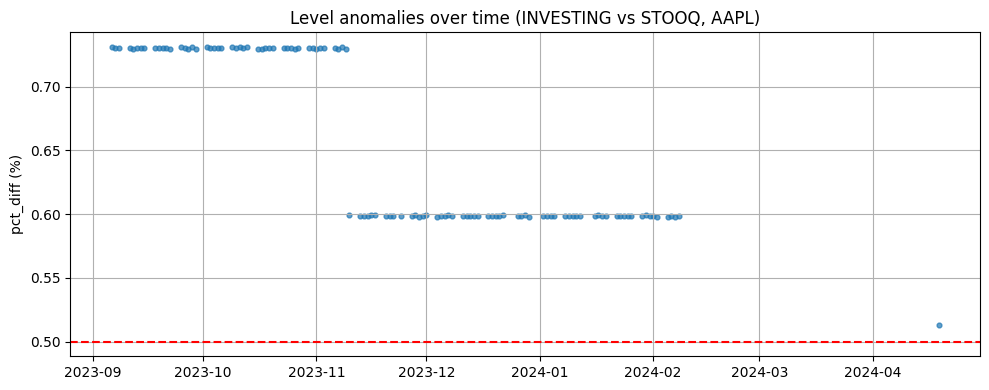

In [8]:
# Extract level anomalies section from reconciliation_report.csv
with open(RECON_PATH, "r", encoding="utf-8") as f:
    lines = f.readlines()

start_idx = None
for i, line in enumerate(lines):
    if line.strip().lower() == "symbol,ts,source_a,price_a,source_b,price_b,pct_diff":
        start_idx = i
        break

levels = pd.DataFrame()
if start_idx is not None:
    stop_idx = None
    for j in range(start_idx+1, len(lines)):
        if lines[j].strip() == "":
            stop_idx = j
            break
    content = "".join(lines[start_idx: stop_idx if stop_idx else len(lines)])
    levels = pd.read_csv(io.StringIO(content))

if not levels.empty:
    levels["ts"] = pd.to_datetime(levels["ts"])
    levels = levels.sort_values("ts")
    plt.figure()
    plt.scatter(levels["ts"], levels["pct_diff"], s=12, alpha=0.7)
    plt.axhline(0.5, linestyle="--", color="red")
    plt.ylabel("pct_diff (%)")
    plt.title("Level anomalies over time (INVESTING vs STOOQ, AAPL)")
    plt.tight_layout()
    plt.show()
else:
    print("No level anomalies section found (or empty).")

In [10]:
# Extract return anomalies section
ret_start = None
for i, line in enumerate(lines):
    if line.strip().lower() == "symbol,ts,source_a,ret_a_pct,source_b,ret_b_pct,abs_diff_pct":
        ret_start = i
        break

returns = pd.DataFrame()
if ret_start is not None:
    returns = pd.read_csv(io.StringIO("".join(lines[ret_start:])))

if not returns.empty:
    returns["ts"] = pd.to_datetime(returns["ts"])
    plt.figure()
    plt.hist(returns["abs_diff_pct"], bins=40)
    plt.title("Distribution of return abs diffs (pct-pts)")
    plt.tight_layout()
    plt.show()
else:
    print("No return anomalies section found (or empty).")

No return anomalies section found (or empty).


## 6. Price & Return Overlay

To visualize methodology bias vs dynamic agreement, we pull AAPL prices 
for both sources from SQLite and compare:

- Overlay of prices (last 90 days)
- Ratio INVESTING/STOOQ
- Day-over-day return differences

Common date range: 2023-09-06 → 2025-09-05, 502 days


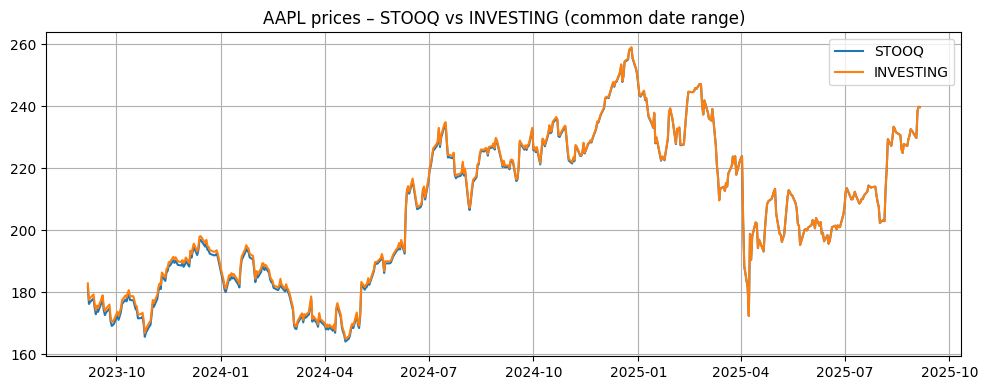

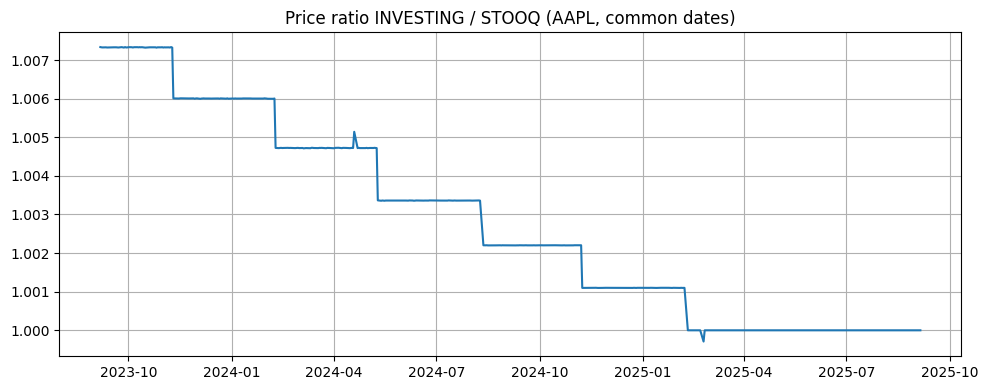

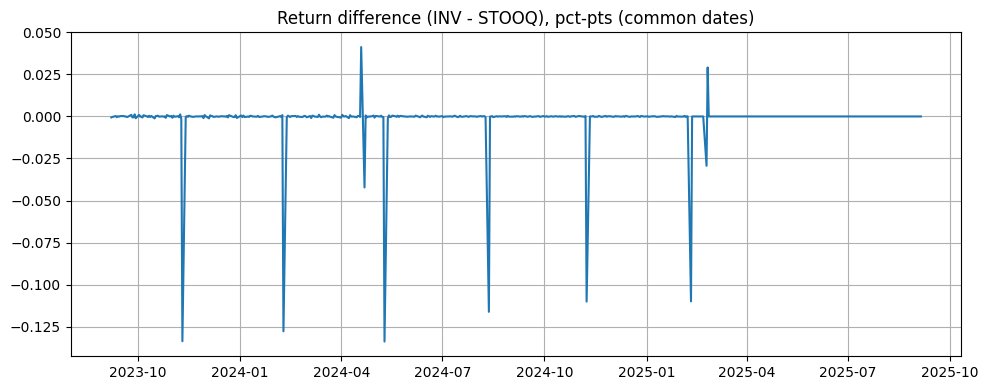

In [13]:
# Pull AAPL prices for both sources
conn = sqlite3.connect(DB_PATH)
df = pd.read_sql_query(
    """
    SELECT symbol, source, ts, price
    FROM raw_prices
    WHERE symbol='AAPL' AND source IN ('STOOQ','INVESTING')
    ORDER BY ts
    """, conn
)
conn.close()

df["ts"] = pd.to_datetime(df["ts"])
pivot = df.pivot_table(index="ts", columns="source", values="price")

# Keep only dates where both sources have data
common = pivot.dropna(subset=["STOOQ","INVESTING"])
print(f"Common date range: {common.index.min().date()} → {common.index.max().date()}, {len(common)} days")

# 1. Overlay prices for the full common period
plt.figure()
plt.plot(common.index, common["STOOQ"], label="STOOQ")
plt.plot(common.index, common["INVESTING"], label="INVESTING")
plt.title("AAPL prices – STOOQ vs INVESTING (common date range)")
plt.legend()
plt.tight_layout()
plt.show()

# 2. Ratio INVESTING/STOOQ
ratio = common["INVESTING"] / common["STOOQ"]
plt.figure()
plt.plot(ratio.index, ratio)
plt.title("Price ratio INVESTING / STOOQ (AAPL, common dates)")
plt.tight_layout()
plt.show()

# 3. Return differences
rets = common.pct_change() * 100.0
diff = (rets["INVESTING"] - rets["STOOQ"]).dropna()
plt.figure()
plt.plot(diff.index, diff)
plt.title("Return difference (INV - STOOQ), pct-pts (common dates)")
plt.tight_layout()
plt.show()


## 7. Interpretation & Business Takeaways

Key findings from this run:

- **Levels reconciliation**: ~20% anomalies triggered at 0.5% threshold. 
  → Caused by systematic methodology bias (e.g., close vs adjusted close, timing differences).  
  → Ratio INVESTING/STOOQ ≈ 1.002 shows a near-constant scale factor.  

- **Returns reconciliation**: 0 anomalies, return correlation ~1.0. 
  → Confirms that both vendors agree perfectly on daily dynamics.  

- **Quality checks**: 2 missing fields, 2 latency anomalies. 
  → Validates that the pipeline detects real data issues early.

**Business value:**
- Governance process that quantifies data quality across vendors.
- Ability to distinguish real anomalies from systematic vendor bias.
- Visual tools (scatter, histogram, overlays) to communicate issues to operations and product.
- Portable design: the same pipeline can be applied to commodities, equities, or derivatives feeds.

**Takeaway for production:**
- Monitor **returns** as the primary indicator of feed consistency.  
- Document vendor methodologies for levels.  
- Set thresholds: ~0.5–1% for levels, 0.1–0.2 pct-pts for returns.  
- Escalate only on sustained anomalies, not one-off differences.


## 8. How to Run

To reproduce this analysis:

1. Run `python src/init_db.py` – create SQLite schema.
2. Run `python src/fetch_real_feeds.py` – fetch raw files (or manually place CSV/JSON into `data/input/`).
3. Run `python src/ingestion.py` – normalize & load into SQLite.
4. Run `python src/quality_checks.py` – generate `data/output/quality_report.csv`.
5. Run `python src/reconciliation.py` – generate `data/output/reconciliation_report.csv`.
6. Open this notebook and run all cells.

**Dependencies:**  
- Python 3.11+  
- Standard library (`os`, `csv`, `sqlite3`)  
- `pandas`, `matplotlib`  

Everything else is included in the repo.  
